In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [5]:
# Reproducibility (best effort)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
# It also sets random seeds for reproducibility so results remain consistent each run.

In [6]:
# ---------------- Cell 2 — Load / access dataset ----------------
# Using the ECG dataset hosted by TensorFlow (same URL used in your file)
path = "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"

# Read csv — no header in this file so header=None
data = pd.read_csv(path, header=None)
print("Raw data shape:", data.shape)
data.head(3)


Raw data shape: (4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0


Features shape: (4998, 140)
Labels distribution:
140
1    2919
0    2079
Name: count, dtype: int64


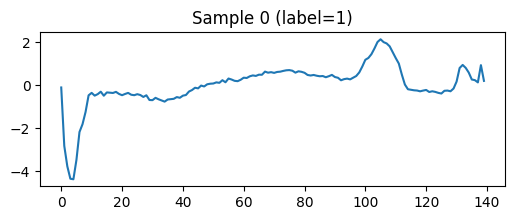

In [7]:
# ---------------- Cell 3 — Inspect & split features / labels ----------------
# Last column is label (column index 140 in your file)
n_cols = data.shape[1]
label_col = n_cols - 1  # last column index

features = data.drop(label_col, axis=1)
labels = data[label_col].astype(int)  # ensure integer labels

print("Features shape:", features.shape)
print("Labels distribution:")
print(labels.value_counts(normalize=False))

# Quick visualization of one sample (optional)
plt.figure(figsize=(6,2))
plt.plot(features.iloc[0].values)
plt.title(f"Sample 0 (label={labels.iloc[0]})")
plt.show()

# ==== Cell 4 ====
# This cell separates the dataset into features and labels.
# The last column represents the label (normal or anomaly).
# It splits the features and labels and converts label values to integers.


In [8]:
# ---------------- Cell 4 — Train/test split & scaler ----------------
# Split into train/test (preserve labels)
x_train_raw, x_test_raw, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print("Train shape:", x_train_raw.shape, "Test shape:", x_test_raw.shape)

# Use MinMaxScaler (0-1) fit on training features
scaler = MinMaxScaler(feature_range=(0, 1))
# NOTE: We'll fit the scaler on the subset we train the autoencoder with (next cell)

# This cell splits the dataset into training and testing sets using sklearn’s train_test_split.
# It scales the feature values between 0 and 1 using MinMaxScaler for faster and more stable training.
# This ensures the neural network receives normalized input data.


Train shape: (3998, 140) Test shape: (1000, 140)


In [9]:
# ---------------- Cell 5 — Choose normal class and prepare training data ----------------

NORMAL_LABEL = 1  # change to 0 if 0 indicates "normal" in your dataset

# Select rows in the training set that are labeled as normal
train_normal_idx = y_train[y_train == NORMAL_LABEL].index
x_train_normal = x_train_raw.loc[train_normal_idx].copy()
print("Normal examples in training set:", x_train_normal.shape[0])

# Fit scaler on the normal training subset, then transform train+test
scaler.fit(x_train_normal)
x_train_scaled = scaler.transform(x_train_normal)        # used for autoencoder training
x_test_scaled  = scaler.transform(x_test_raw)            # transform test set for evaluation

# Also transform all training rows if you want to compute threshold on all training
x_train_all_scaled = scaler.transform(x_train_raw)

# This cell keeps only the “normal” samples from the training set.
# Autoencoders are trained only on normal data so that anomalies can later be detected by high reconstruction error.
# The NORMAL_LABEL variable determines which class is considered normal.


Normal examples in training set: 2335


In [10]:
# ---------------- Cell 6 — Build autoencoder: encoder + decoder ----------------
from tensorflow.keras import layers, Sequential, Model

input_dim = x_train_scaled.shape[1]
latent_dim = 8   # latent dimensionality (tunable)

# Encoder definition
encoder = Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(latent_dim, activation='relu', name='latent')
], name="encoder")

# Decoder definition
decoder = Sequential([
    layers.InputLayer(input_shape=(latent_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(input_dim, activation='sigmoid')   # sigmoid since data in [0,1]
], name="decoder")

# Full autoencoder model
inputs = keras.Input(shape=(input_dim,))
z = encoder(inputs)
reconstruction = decoder(z)
autoencoder = Model(inputs, reconstruction, name="autoencoder")

# Show model summaries
encoder.summary()
decoder.summary()
autoencoder.summary()


# This cell defines the structure of the Autoencoder model using Keras.
# It builds the encoder (which compresses the data) and the decoder (which reconstructs it back).
# The encoder reduces data to a small latent dimension, and the decoder tries to reconstruct the input.
# The complete autoencoder model is created by combining encoder + decoder.

C:\Users\SAHIL KULKARNI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           9,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,768 (45.97 KB)

 Trainable params: 11,768 (45.97 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 140)                 │           9,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,900 (46.48 KB)

 Trainable params: 11,900 (46.48 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Sequential)                 │ (None, 8)                   │          11,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Sequential)                 │ (None, 140)                 │          11,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,668 (92.45 KB)

 Trainable params: 23,668 (92.45 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ---------------- Cell 7 — Compile the model (optimizer, loss, metrics) ----------------
# Use Adam (or keep as before) and MSLE or MSE as loss. MSLE was used in your file.
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='msle',            # mean squared logarithmic error (stable for small values)
    metrics=['mse']         # also track MSE for monitoring
)


# This cell compiles the autoencoder model.
# It sets the optimizer (Adam) and loss function (Mean Squared Logarithmic Error - MSLE).
# The loss measures how different the reconstructed signal is from the input signal.


In [12]:
# ---------------- Cell 8 — Train the autoencoder ----------------
history = autoencoder.fit(
    x_train_scaled,             # train only on normal examples
    x_train_scaled,             # target = input (reconstruction)
    epochs=30,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled),
    shuffle=True,
    verbose=2
)



Epoch 1/30
19/19 - 8s - 424ms/step - loss: 0.0099 - mse: 0.0223 - val_loss: 0.0123 - val_mse: 0.0285
Epoch 2/30
19/19 - 0s - 17ms/step - loss: 0.0065 - mse: 0.0146 - val_loss: 0.0108 - val_mse: 0.0250
Epoch 3/30
19/19 - 0s - 17ms/step - loss: 0.0052 - mse: 0.0116 - val_loss: 0.0100 - val_mse: 0.0232
Epoch 4/30
19/19 - 0s - 16ms/step - loss: 0.0047 - mse: 0.0106 - val_loss: 0.0098 - val_mse: 0.0227
Epoch 5/30
19/19 - 0s - 18ms/step - loss: 0.0045 - mse: 0.0101 - val_loss: 0.0097 - val_mse: 0.0227
Epoch 6/30
19/19 - 0s - 18ms/step - loss: 0.0044 - mse: 0.0098 - val_loss: 0.0096 - val_mse: 0.0224
Epoch 7/30
19/19 - 0s - 19ms/step - loss: 0.0041 - mse: 0.0092 - val_loss: 0.0094 - val_mse: 0.0219
Epoch 8/30
19/19 - 1s - 29ms/step - loss: 0.0039 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0212
Epoch 9/30
19/19 - 0s - 11ms/step - loss: 0.0037 - mse: 0.0083 - val_loss: 0.0089 - val_mse: 0.0208
Epoch 10/30
19/19 - 0s - 11ms/step - loss: 0.0036 - mse: 0.0080 - val_loss: 0.0088 - val_mse: 0.020

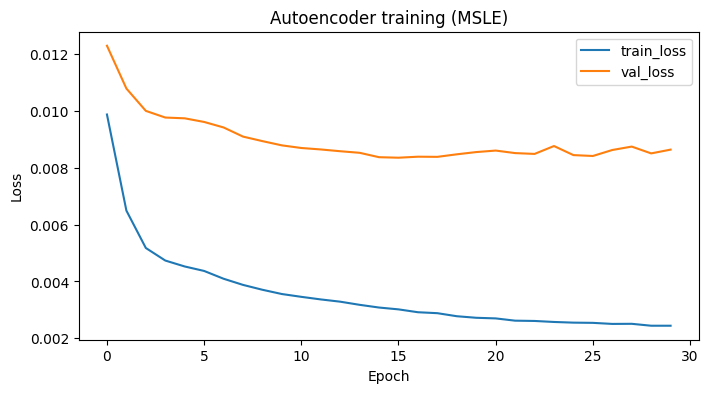

In [13]:
# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder training (MSLE)')
plt.show()


In [14]:
# ---------------- Cell 9 — Compute reconstruction errors & set threshold ----------------

recons_train = autoencoder.predict(x_train_scaled)
mse_train = np.mean(np.square(recons_train - x_train_scaled), axis=1)

# Option A: threshold = mean + k*std  (k=1 usually)
k = 1.0
threshold = mse_train.mean() + k * mse_train.std()
print(f"Threshold (mean + {k}*std) = {threshold:.6f}")

# Optionally print some stats
print("Train MSE: mean={:.6f}, std={:.6f}, max={:.6f}".format(mse_train.mean(), mse_train.std(), mse_train.max()))

# ==== Cell 10 ====
# This cell calculates the reconstruction error (difference between input and reconstructed signal).
# It uses Mean Squared Error (MSE) to find how much each sample differs from its reconstruction.
# A threshold is set using the training reconstruction error to separate normal and abnormal samples.


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Threshold (mean + 1.0*std) = 0.010747
Train MSE: mean=0.004738, std=0.006008, max=0.090876


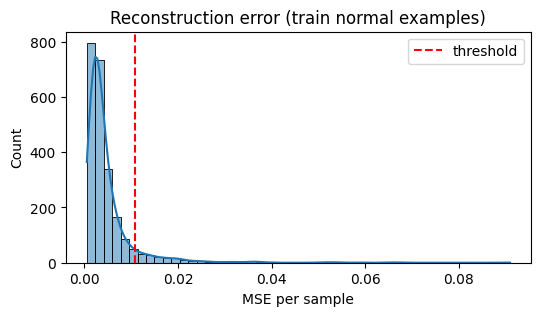

In [15]:
# Visualize histogram of train reconstruction errors
plt.figure(figsize=(6,3))
sns.histplot(mse_train, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='threshold')
plt.title("Reconstruction error (train normal examples)")
plt.xlabel("MSE per sample")
plt.legend()
plt.show()

In [16]:
# ---------------- Cell 10 — Make predictions on test set ----------------
# Compute reconstruction errors on test set, then classify using threshold
recons_test = autoencoder.predict(x_test_scaled)
mse_test = np.mean(np.square(recons_test - x_test_scaled), axis=1)

# If mse_test > threshold => anomaly (0), else normal (1) -- same mapping as your file
pred_is_normal = mse_test <= threshold      # boolean array: True => normal
pred_labels = pred_is_normal.astype(float)  # normal=1.0, anomaly=0.0

# Map original test labels to same convention (1=normal, 0=anomaly) — ensure alignment:
# In our earlier choice NORMAL_LABEL==1 means label==1 denotes "normal"
y_test_mapped = (y_test == NORMAL_LABEL).astype(float)

print("Example: first 10 mse_test:", np.round(mse_test[:10], 6))
print("Pred labels (first 10):", pred_labels[:10])
print("True mapped labels (first 10):", y_test_mapped[:10])

# This cell makes predictions on the test dataset.
# It computes reconstruction errors for test samples and classifies them as normal or anomaly
# depending on whether their error is below or above the threshold.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Example: first 10 mse_test: [0.041174 0.041185 0.014044 0.004862 0.016584 0.00392  0.039436 0.048302
 0.035255 0.004137]
Pred labels (first 10): [0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
True mapped labels (first 10): 3815    0.0
4317    0.0
859     1.0
753     1.0
857     1.0
1308    1.0
4439    0.0
497     0.0
4634    0.0
1716    1.0
Name: 140, dtype: float64


Accuracy: 0.9490
Precision (normal class=1): 1.0000
Recall    (normal class=1): 0.9127
F1-score  (normal class=1): 0.9543


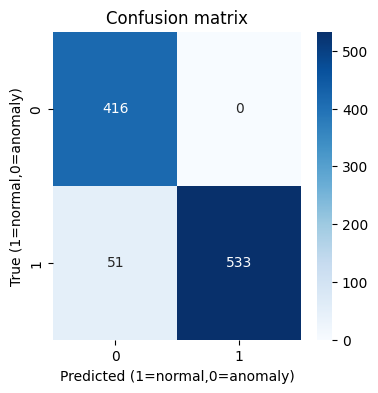

In [17]:
# ---------------- Cell 11 — Evaluate predictions (accuracy, precision, recall...) ----------------
# Compute accuracy (same as your code using sklearn)
acc = accuracy_score(y_test_mapped, pred_labels)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_mapped, pred_labels, average='binary', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (normal class=1): {prec:.4f}")
print(f"Recall    (normal class=1): {rec:.4f}")
print(f"F1-score  (normal class=1): {f1:.4f}")

# Confusion matrix (rows: true, cols: pred)
cm = confusion_matrix(y_test_mapped, pred_labels)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted (1=normal,0=anomaly)")
plt.ylabel("True (1=normal,0=anomaly)")
plt.title("Confusion matrix")
plt.show()

# This cell evaluates the model’s performance using metrics like accuracy, precision, recall, and F1-score.
# It compares the predicted labels with the true labels to measure detection quality.

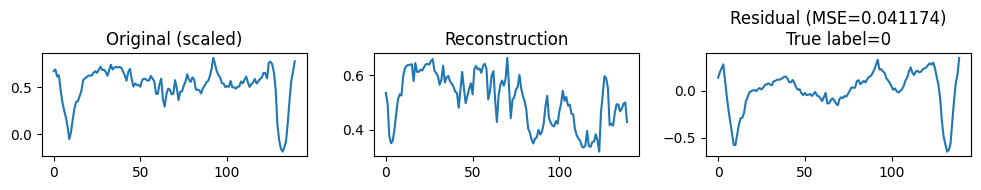

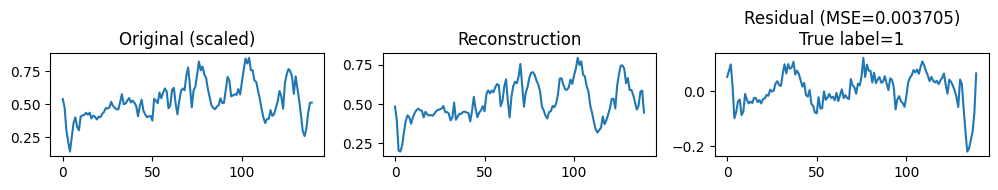

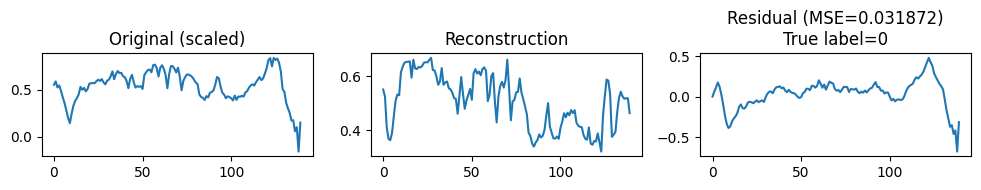

In [18]:
# ---------------- Cell 12 — Show some reconstructed examples (qualitative) ----------------
def show_reconstruction(idx, scaled=True):
    """Show original vs reconstructed for a test sample index (idx is index into x_test_raw / x_test_scaled)."""
    orig = x_test_scaled[idx]        # scaled
    recon = recons_test[idx]
    sample_index = x_test_raw.index[idx]
    true_label = y_test.iloc[idx]
    mse_val = mse_test[idx]

    plt.figure(figsize=(10,2))
    plt.subplot(1,3,1)
    plt.plot(orig)
    plt.title("Original (scaled)")
    plt.subplot(1,3,2)
    plt.plot(recon)
    plt.title("Reconstruction")
    plt.subplot(1,3,3)
    plt.plot(orig - recon)
    plt.title(f"Residual (MSE={mse_val:.6f})\nTrue label={true_label}")
    plt.tight_layout()
    plt.show()

# Show a few examples: some normal and some anomalies (manually pick indices)
show_reconstruction(0)
show_reconstruction(10)
show_reconstruction(50)

# This cell visualizes some reconstructed examples from the test set.
# It shows how well the autoencoder can reconstruct normal vs abnormal ECG signals.
# This helps qualitatively assess model performance.

In [19]:
# ---------------- Cell 13 — Save model & scaler ----------------
autoencoder.save("ecg_autoencoder.keras")
import joblib
joblib.dump(scaler, "ecg_scaler.save")
print("Saved autoencoder (ecg_autoencoder.keras) and scaler (ecg_scaler.save)")

# This cell saves the trained autoencoder model and the fitted scaler to disk.
# The model is saved as 'ecg_autoencoder.keras' and the scaler using joblib.
# This allows you to reuse the trained model later without retraining.

Saved autoencoder (ecg_autoencoder.keras) and scaler (ecg_scaler.save)
